# **ASTR19 FINAL PROJECT**

## Setup: Pip Installing, importing libraries, and plotting initial graph

These libraries are already installed on my computer, but below is how I'd install the libraries.

In [19]:
import numpy as np
import sep
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [20]:
rcParams ['figure.figsize'] = [10.,8.]
fits_image_filename = fits.util.get_testdata_filepath('test0.fits')
hdul = fits.open("/Users/luxmorgan/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

In [21]:
data = hdul[0].data

After reading in the data from the fits file, 

In [ ]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation = "nearest", cmap = "bone", vmin = m - s, vmax = m+s, origin = "lower")
plt.colorbar()
plt.savefig ("astr19_final_image_1.png")

## Background Subtraction
***In order to accurrately detect objects, the background should be subtracted.***

The code was having issues with swapping byte data, so I needed to include an extra cell of code to account for that.

In [22]:
#this cell is to account for correctly swapping byte data
new_data = data.astype(data.dtype.newbyteorder("="))
new_data = data.byteswap()
new_data = new_data.view(new_data.dtype.newbyteorder("="))
data = data.byteswap()
data = data.view(data.dtype.newbyteorder("="))

In [23]:
# measure spatially varying background on the image. 
#really all you need is (data) but there's options for controlling box size and masking pixels.
bkg = sep.Background(data)
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [9]:
#evaluate the background as a 2d array, same size as the original.
bkg_image = bkg.back()
#bkg_image = np.array(bkg) # this is an equivalent to above

Below is the background of the image. I really like the "bone" color map because it sticks to the same value scale as grey but has a subtle hue shift from purple to a desaturated, cool blue.

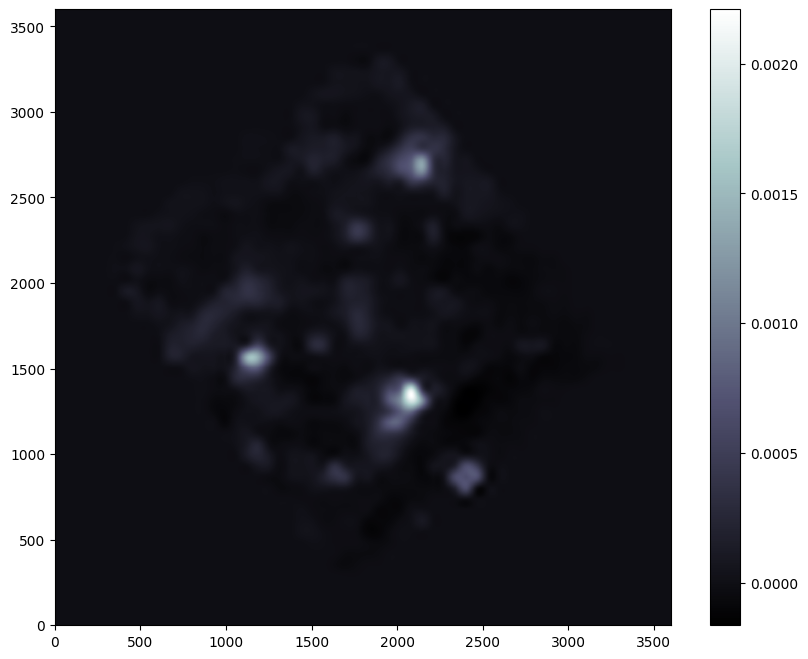

In [25]:
#show the background neow
plt.imshow(bkg_image, interpolation = "nearest", cmap = "bone", origin = "lower")
plt.colorbar();
plt.savefig ("astr19_final_image_2.png")

...And below here is the background noise.

In [30]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

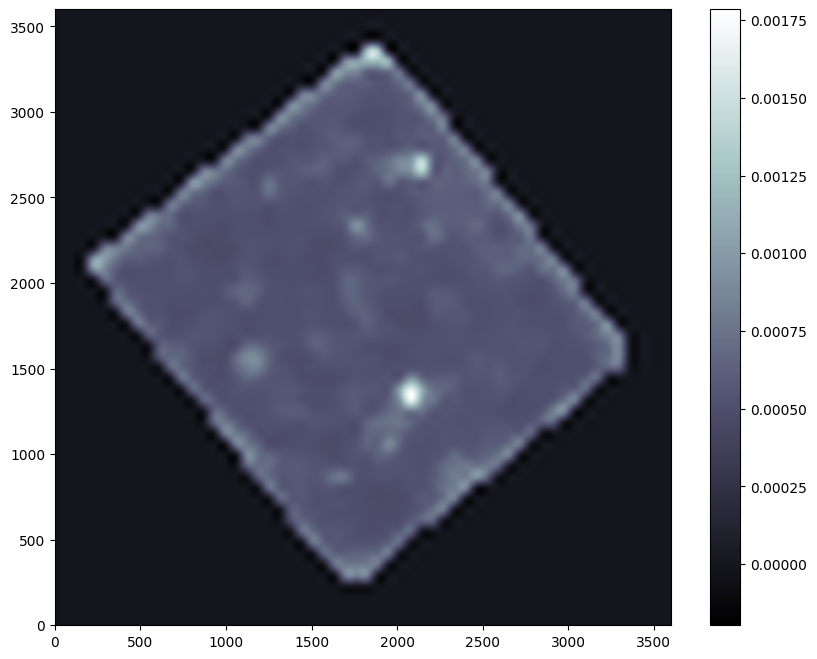

In [31]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='bone', origin='lower')
plt.colorbar();
plt.savefig("astr19_final_image_3.png")

## Detecting and Plotting the Objects

I decided on 5 for the sigma, as opposed to the original tutorial's 1.5, to account for the amount of noise present in this image. Originally, I thought it needed to be much higher to limit as much noise as possible and thus account for uncertainty, but then I thought it through a little more and realized that meant a much higher number of deviations away from the mean. So many objects in one image!

I printed the amount of objects detected to get a sense of how many we'd be dealing with in our dataset, because I wanted a sense of scale, and I wanted to know generally how many bins I'd need to make in the histogram.

In [32]:
data_sub = data - bkg
objects = sep.extract(data_sub,  5, err=bkg.globalrms)
#this is how many objects were detected
len(objects)
print(len(objects))

2633


And here is the final image detecting and labeling every object with a circle. This was particularly useful in running repeatedly with the different sigma value to see if noise was accounted for. Originally my plot was a big, scary, red diamond. But now it's a lot more coherent.

0.0007716763 0.05486398


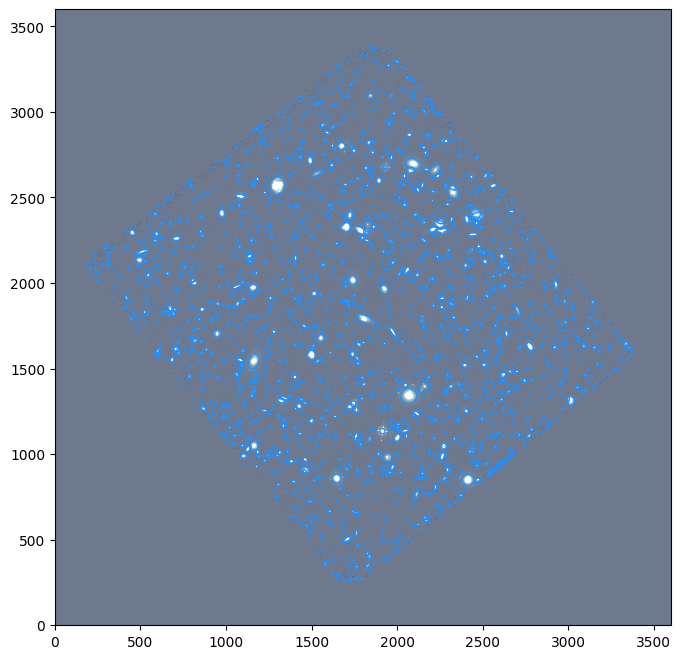

In [33]:

from matplotlib.patches import Ellipse

# plotting the background-subtracted image to see the data itself
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='bone',
               vmin=m-s, vmax=m+s, origin='lower')
#printing to see the mean and std of the datapoints without the background noise.
print (m, s) 

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('dodgerblue')
    ax.add_artist(e)
plt.savefig ("astr19_final_image_4.png")

The cell below wasn't necessary to the steps required for the final project, but it was a good way to ensure that everything was working accordingly.

In [34]:
flux, fluxerr, flag = sep.sum_circle(data_sub,objects['x'],objects['y'],
                                     5.0, err=bkg.globalrms, gain=1.0)
#flux, fluxerr and flag are all 1d arrays with one entry per object.
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = -0.035845 +/- 0.004788
object 1: flux = 0.105811 +/- 0.325321
object 2: flux = 0.093705 +/- 0.306151
object 3: flux = 0.096769 +/- 0.311115
object 4: flux = 0.062107 +/- 0.249258
object 5: flux = 0.123415 +/- 0.351337
object 6: flux = 0.045614 +/- 0.213627
object 7: flux = 0.039678 +/- 0.199251
object 8: flux = 0.069499 +/- 0.263671
object 9: flux = 0.027540 +/- 0.166020


## Plotting a Histogram of the Fluxes

This took quite a while for me to figure out. Taking the natural log of the flux value creates a much more smoother, graduated graph that still accounts for potential outliers and displays the distribution. Originally, I set the number of bins equal to the number of objects and, well, that just made everything incomprehensible. 50 was a much more reasonable amount of bins -- it's enough to get a sense of the data without sacrificing the viewer's ability to understand what they're looking at. Yay!

And, of course, I wanted to customize the histogram a little to match the color scheme of the rest of the assignment so far.

/var/folders/m_/cl4g5ftn0kv4yv04dc88wl3c0000gn/T/ipykernel_88974/2217393179.py:2: RuntimeWarning: invalid value encountered in log
  log_flux = np.log(flux)


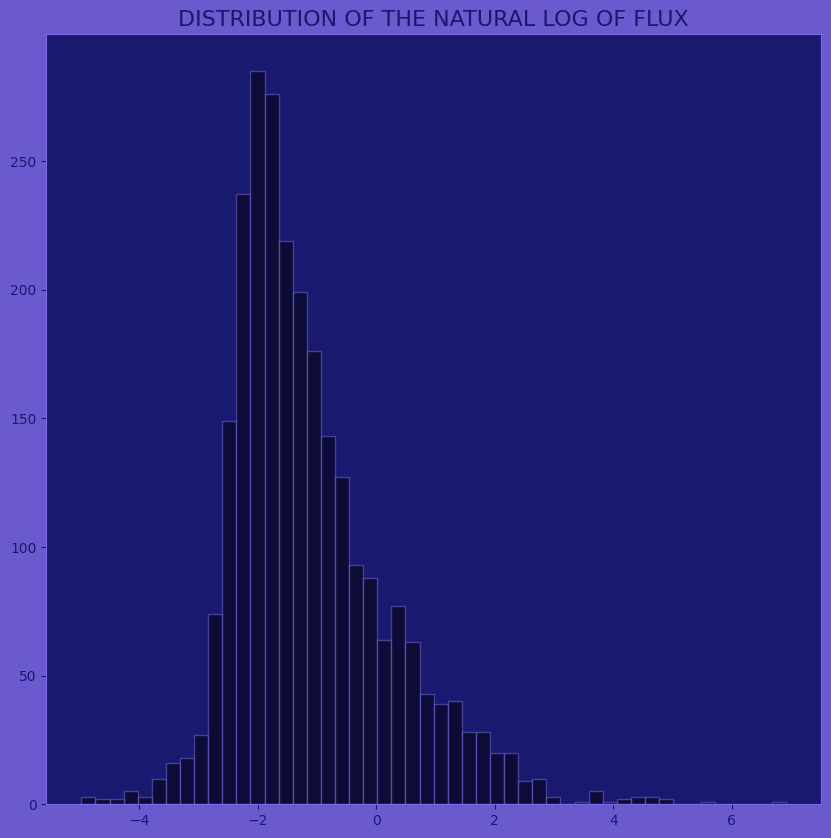

In [147]:
#create the histogram. taking the log of 10 will create a more even distribution, as opposed to every datapoint in a single bin.
log_flux = np.log(flux)
histmin = np.floor(min(log_flux))
histmax = np.ceil(max(log_flux))


plt.figure(figsize=(10,10), facecolor = "slateblue")
ax = plt.subplot (111, facecolor = "midnightblue")
bins = 50 #originally i set the bins equal to the number of objects, but this lef to a lot of incoherent data. we still need enough to understand what we're looking at though.
plt.hist(log_flux,bins=bins, alpha=0.5, facecolor="black",edgecolor="mediumslateblue")
plt.title("DISTRIBUTION OF THE NATURAL LOG OF FLUX", fontsize=16, color = "midnightblue")
ax.tick_params(colors = "midnightblue")
for spine in ["bottom", "top", "left", "right"]:
    ax.spines[spine].set_color("mediumslateblue")

In [148]:
print((np.mean(flux)))
print(np.std(flux))
print(np.max(flux))
print(np.var(flux))

1.795236835191394
21.261786136192107
1003.9282738018035
452.0635497011709


## Mean, STD, and the Variance
According to the printing above, the mean of the fluxes is about 1.795 and the standard deviation is roughly 21.262. The maximum flux is ~1003.928, which is ~452.06 deviations away from the standard deviation. On the histogram itself, it's the highest point located to the left side of the graph around -2 on the X axis. **This is a really significant outlier!**

## Creating the 3-Color False Image

First, we need to read in all of the additional fits files.

In [149]:
fdata_f160w = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"
fdata_f125w = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_f105w = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

hdu_1 = fits.open("/Users/luxmorgan/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")
hdu_2 = fits.open("/Users/luxmorgan/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
hdu_3 = fits.open("/Users/luxmorgan/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

data_1 = hdu_1[0].data
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data

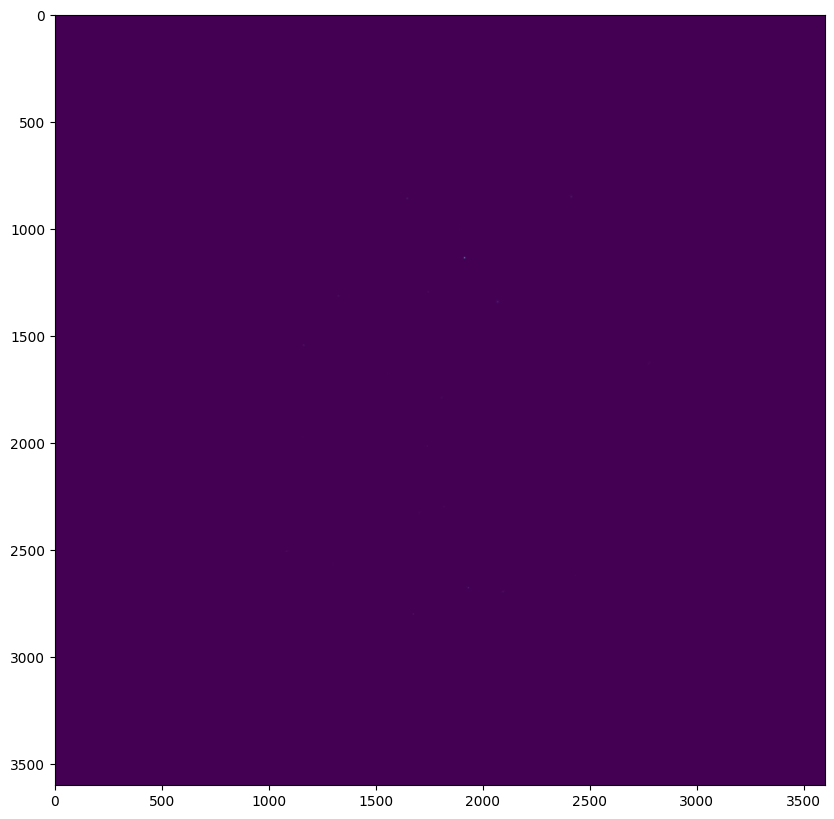

In [150]:
f = plt.figure(figsize=(10,10))
plt.imshow(data_1)

The figure is blank, but that means it's going smoothly so far. Next are two functions, one of which rescales the image's data so we can get a visual on the planets, and another to plot that rescaled data and ensure everything is visible.

In [151]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax

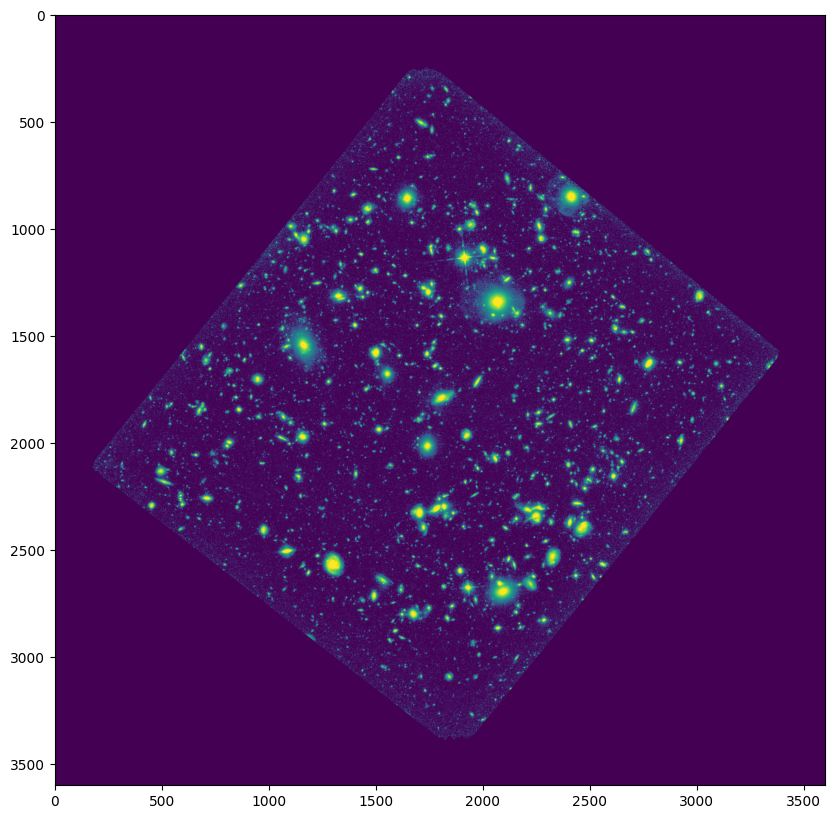

In [152]:
def fits_quicklook(data,fnx=10,fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp,vplmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vplmin,vmax=vpmax)
fits_quicklook(data_2)

**It's from this data that the final 3-color RGB image is made.** 

In [153]:
data_1_res, d1min, d1max = rescale_image(data_1)
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)

**Limiting the data** to be between the minimum and maximum values after rescaling.

In [154]:
data_1_res[data_1_res<d1min] = d1min
data_1_res[data_1_res>d1max] = d1max
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max
data_3_res[data_1_res<d3min] = d3min
data_3_res[data_1_res>d3max] = d3max

Below, I'm setting each file to either display the red, green, or blue values. These are then overlaid to make the final RGB image.

In [155]:
rgb = np.zeros((data_1_res.shape[0], data_1_res.shape[1], 3))
rgb[:,:,0] = (data_1_res-d1min)/(d1max-d1min)
rgb[:,:,1] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,2] = (data_3_res-d3min)/(d3max-d3min)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1297450065612793].


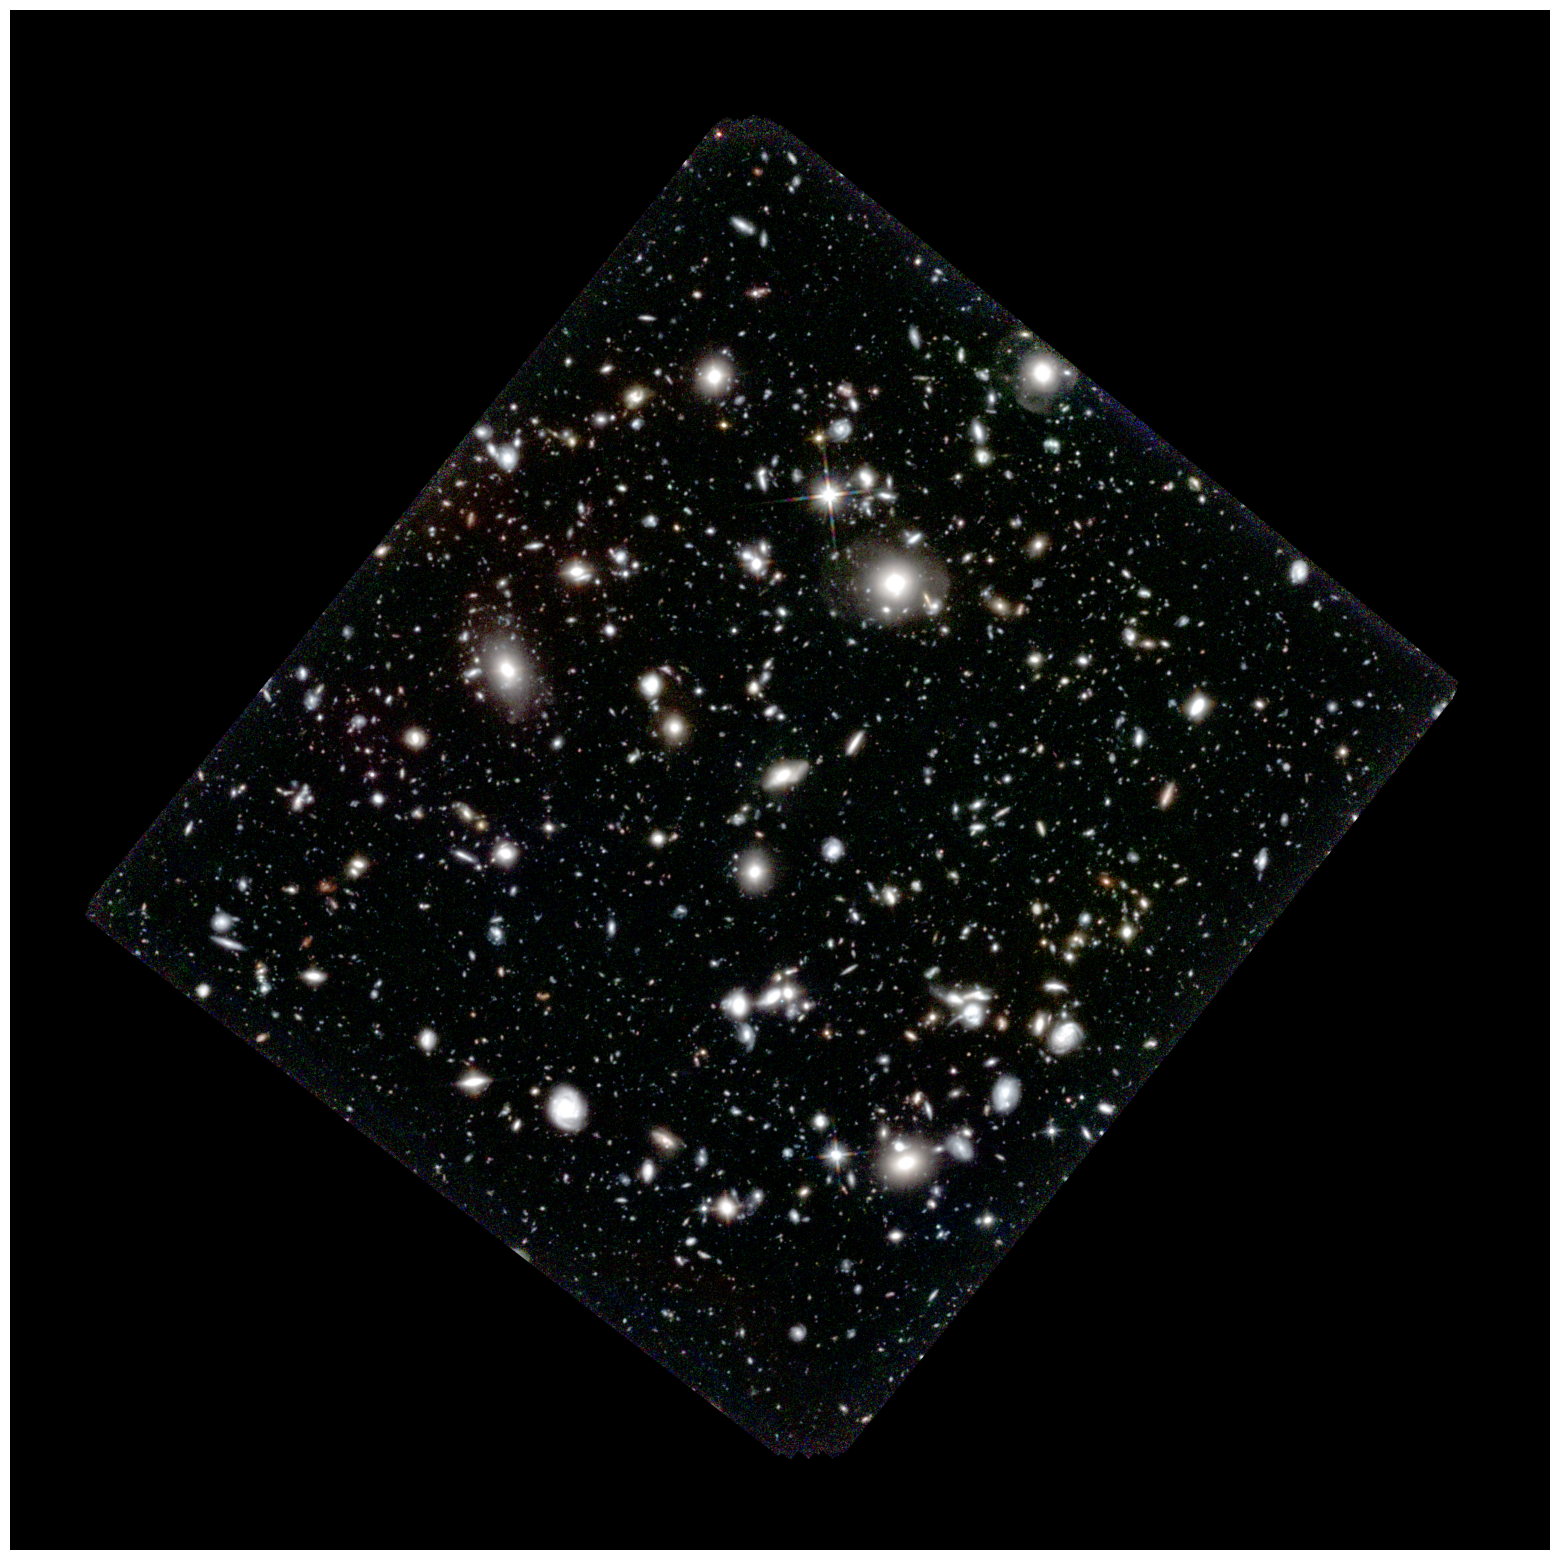

In [156]:
f, ax = plt.subplots(1,1,figsize=(20,20))
ax.axis("off")
ax.imshow(rgb)
plt.savefig("astr19_final_image_5.png")

# Thanks for the wonderful class! I had so much fun in ASTR19!
### - Lux Morgan